## Imports and Data Loading

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.utils import resample
import scipy
from numpy.fft import fft
import seaborn as sns

In [2]:
# load data
hr = pd.read_csv('data/alpaca_hr.csv')
resp = pd.read_csv('data/alpaca_resp.csv')
sao2 = pd.read_csv('data/alpaca_sao2.csv')

hr['offset'] = hr['offset'] / 60
resp['offset'] = resp['offset'] / 60
sao2['offset'] = sao2['offset'] / 60

gcs = pd.read_csv('data/patient_motor.csv')
gcs = gcs[gcs['observationoffset'] > -1]
gcs['observationoffset'] = gcs['observationoffset'] / 60
final_gcs_id = gcs.groupby('patientunitstayid')['observationoffset'].transform(max) == gcs['observationoffset']

final_gcs = gcs[final_gcs_id]
display(final_gcs)

#display(hr)
#display(resp)
#display(sao2)

,patientunitstayid,observationoffset,Key,Value,origin
0,172448,2.500000,Motor,1.0,nurse_charting
31,242714,46.850000,Motor,6.0,nurse_charting
40,242825,12.733333,Motor,6.0,nurse_charting
45,243176,54.566667,Motor,6.0,nurse_charting
86,243493,59.033333,Motor,6.0,nurse_charting
...,...,...,...,...,...
135846,3351268,187.383333,Motor,6.0,nurse_charting
135847,3351533,29.583333,Motor,6.0,nurse_charting
135858,3351909,156.950000,Motor,6.0,nurse_charting
135900,3352618,346.600000,Motor,6.0,nurse_charting


In [94]:
# Loading lab data
lab = pd.read_csv('data/lab_data.csv')
lab = lab[lab['labresultoffset'] > -1]
lab = lab[lab['labresultoffset'] <= 24*60]
# display(lab)
labtypes = list(lab['labname'].drop_duplicates())

In [ ]:
# Getting table of averages over first 24 hours
l = labtypes[0]
labtypedata = lab[lab['labname'] == l]
labtypedata_avgs = labtypedata.groupby('patientunitstayid').mean()['labresult']
labtypedata_avgs = labtypedata_avgs.to_frame()
labtypedata_avgs = labtypedata_avgs.reset_index()
labtypedata_avgs =labtypedata_avgs.rename(columns = {'labresult':l})
for l in labtypes[1:]:
    labtypedata = lab[lab['labname'] == l]
    labtypedata_avgs1 = labtypedata.groupby('patientunitstayid').mean()['labresult']
    labtypedata_avgs1 = labtypedata_avgs1.to_frame()
    labtypedata_avgs1 = labtypedata_avgs1.reset_index()
    labtypedata_avgs1 =labtypedata_avgs1.rename(columns = {'labresult':l})
    labtypedata_avgs = labtypedata_avgs.merge(labtypedata_avgs1, how='outer', on='patientunitstayid')

In [96]:
labtypedata_avgs.head()

,patientunitstayid,bedside glucose,PTT,Hct,Vancomycin - trough,PT,PT - INR,-eos,Hgb,MCV,...,WBC's in pleural fluid,Gentamicin - random,WBC's in body fluid,Tobramycin - random,Mode,protein C,protein S,HSV 1&2 IgG AB,Site,CRP-hs
0,143094,238.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,143103,146.000000,NaN,34.2,NaN,10.8,1.1,0.0,12.10,85.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,144116,214.666667,26.0,41.7,NaN,11.5,1.1,1.0,13.50,85.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,145396,129.000000,27.0,32.7,NaN,10.7,1.0,0.0,11.30,84.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,145840,217.500000,NaN,42.1,NaN,NaN,NaN,0.0,14.65,95.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
lab_avgs_map = {}
for l in labtypes:
    if l in labtypedata_avgs.columns:
        col = list(labtypedata_avgs[l].dropna())
        if len(col) != 0:
            avg = sum(col)/len(col)
            lab_avgs_map[l] = avg
        else:
            labtypedata_avgs = labtypedata_avgs.drop(columns=l)
# print(lab_avgs_map)

In [122]:
# Filling in na values for labtypedata_avgs.columns with averages
# for that column
for l in labtypedata_avgs.columns:
    if l != 'patientunitstayid':
        col = labtypedata_avgs[l]
        labtypedata_avgs[l] = col.fillna(lab_avgs_map[l])
labtypedata_avgs.head()

,patientunitstayid,bedside glucose,PTT,Hct,Vancomycin - trough,PT,PT - INR,-eos,Hgb,MCV,...,prolactin,T3,WBC's in pleural fluid,Gentamicin - random,WBC's in body fluid,Tobramycin - random,Mode,protein C,protein S,CRP-hs
0,143094,238.000000,30.768818,34.79829,14.51129,14.901195,1.256691,0.888963,11.66444,90.809447,...,15.133333,67.0,2197.0,4.05,898.0,8.633333,15.0,105.333333,89.0,52.2
1,143103,146.000000,30.768818,34.20000,14.51129,10.800000,1.100000,0.000000,12.10000,85.900000,...,15.133333,67.0,2197.0,4.05,898.0,8.633333,15.0,105.333333,89.0,52.2
2,144116,214.666667,26.000000,41.70000,14.51129,11.500000,1.100000,1.000000,13.50000,85.300000,...,15.133333,67.0,2197.0,4.05,898.0,8.633333,15.0,105.333333,89.0,52.2
3,145396,129.000000,27.000000,32.70000,14.51129,10.700000,1.000000,0.000000,11.30000,84.700000,...,15.133333,67.0,2197.0,4.05,898.0,8.633333,15.0,105.333333,89.0,52.2
4,145840,217.500000,30.768818,42.10000,14.51129,14.901195,1.256691,0.000000,14.65000,95.800000,...,15.133333,67.0,2197.0,4.05,898.0,8.633333,15.0,105.333333,89.0,52.2


In [113]:
# Getting table of measurement counts over first 24 hours
l = labtypes[0]
labtypedata = lab[lab['labname'] == l]
labtypedata_cts = labtypedata.groupby('patientunitstayid').count()['labresult']
labtypedata_cts = labtypedata_cts.to_frame()
labtypedata_cts = labtypedata_cts.reset_index()
labtypedata_cts =labtypedata_cts.rename(columns = {'labresult':l})
for l in labtypes[1:]:
    labtypedata = lab[lab['labname'] == l]
    labtypedata_cts1 = labtypedata.groupby('patientunitstayid').count()['labresult']
    labtypedata_cts1 = labtypedata_cts1.to_frame()
    labtypedata_cts1 = labtypedata_cts1.reset_index()
    labtypedata_cts1 =labtypedata_cts1.rename(columns = {'labresult':l})
    labtypedata_cts = labtypedata_cts.merge(labtypedata_cts1, how='outer', on='patientunitstayid')
    
# Since these are counts, filling na with zeros
labtypedata_cts = labtypedata_cts.fillna(0)

In [114]:
labtypedata_cts.head()

,patientunitstayid,bedside glucose,PTT,Hct,Vancomycin - trough,PT,PT - INR,-eos,Hgb,MCV,...,WBC's in pleural fluid,Gentamicin - random,WBC's in body fluid,Tobramycin - random,Mode,protein C,protein S,HSV 1&2 IgG AB,Site,CRP-hs
0,143094,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,143103,20.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,144116,3.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,145396,12.0,4.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,145840,4.0,0.0,2.0,0.0,0.0,0.0,1.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
# NOTE: Need to do this SEPARATELY for train/val/test
# deal with nan
interplim = 1000
hr = hr.groupby('patientunitstayid').apply(lambda group: group.interpolate(method='linear', limit = interplim))
resp = resp.groupby('patientunitstayid').apply(lambda group: group.interpolate(method='linear', limit = interplim))
sao2 = sao2.groupby('patientunitstayid').apply(lambda group: group.interpolate(method='linear', limit = interplim))

#for now drop Nan rows (shouldn't be many)...
hr = hr.dropna()
resp = resp.dropna()
sao2 = sao2.dropna()

display(hr.loc[hr['patientunitstayid'] == 143274])

,patientunitstayid,offset,value
12,143274,1.016667,95.0
13,143274,1.100000,97.0
14,143274,1.183333,97.0
15,143274,1.266667,98.0
16,143274,1.350000,98.0
17,143274,1.433333,99.0
18,143274,1.516667,98.0
19,143274,1.600000,98.0
20,143274,1.683333,99.0
21,143274,1.766667,99.0


## Set Parameters

In [4]:
# prediction frequency refers to the frequency with which we want to predict GCS
prediction_freq = 2

# summarization interval refers to the spacing between edges of the bins of our histogram (for summarizing physiology)
summarization_int = 0.25

## Bin data

In [5]:
# split data into bins based on summarization_int
bins=np.arange(25, step=summarization_int)
hr['offset_bin'] = pd.cut(hr['offset'], bins, labels=list(np.arange(bins.shape[0] - 1)))
#display(hr[hr['patientunitstayid'] == 318676])
hr_grouped = hr.groupby(['patientunitstayid', 'offset_bin']).mean().reset_index()
#hr_grouped['patientunitstayid'] = hr_grouped['patientunitstayid'].astype(int)

resp['offset_bin'] = pd.cut(resp['offset'], bins, labels=list(np.arange(bins.shape[0] - 1)))
resp_grouped = resp.groupby(['patientunitstayid', 'offset_bin']).mean().reset_index()
#resp_grouped['patientunitstayid'] = resp_grouped['patientunitstayid'].astype(int)

sao2['offset_bin'] = pd.cut(sao2['offset'], bins, labels=list(np.arange(bins.shape[0] - 1)))
sao2_grouped = sao2.groupby(['patientunitstayid', 'offset_bin']).mean().reset_index()
#sao2_grouped['patientunitstayid'] = sao2_grouped['patientunitstayid'].astype(int)

gcs['offset_bin'] = pd.cut(gcs['observationoffset'], bins, labels=list(np.arange(bins.shape[0] - 1)))
gcs_grouped = gcs.groupby(['patientunitstayid', 'offset_bin']).mean().reset_index()
gcs_grouped['offset'] = gcs_grouped['observationoffset']
gcs_grouped['value'] = gcs_grouped['Value']
gcs_grouped = gcs_grouped.drop(['observationoffset', 'Value'], axis = 1)
#gcs_grouped['patientunitstayid'] = gcs_grouped['patientunitstayid'].astype(int)

## Plot Samples

/home/adit/.virtualenvs/pcm/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


Text(0.5, 1.0, 'Motor GCS')

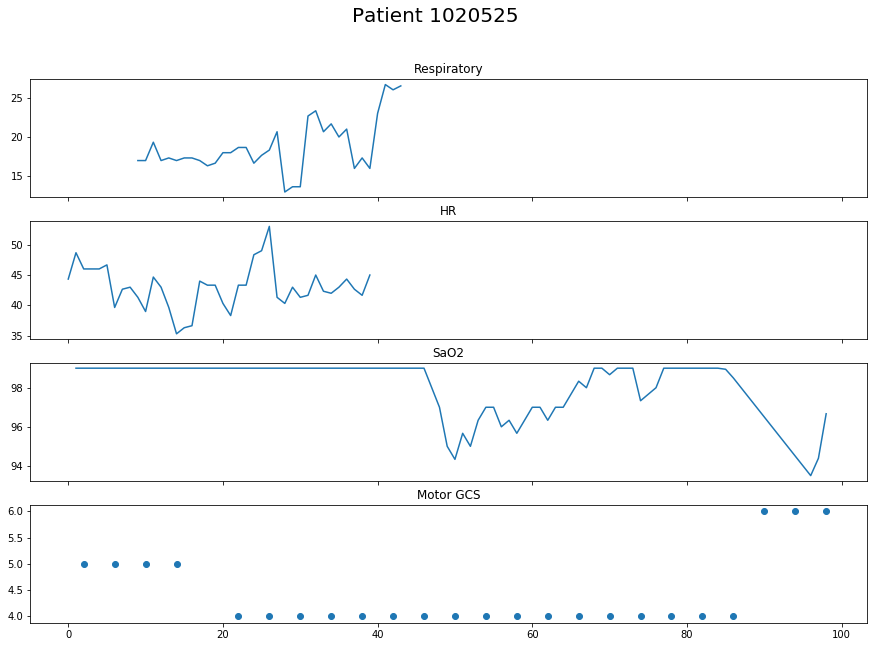

In [6]:
# get one patient's data
ind_slice = np.argwhere(hr_grouped['patientunitstayid'] == 1020525).flatten()
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(15,10))
f.suptitle("Patient 1020525", size = 20)
ax1.plot(np.arange(resp_grouped[resp_grouped.index.isin(ind_slice)]['value'].shape[0]),
         resp_grouped[resp_grouped.index.isin(ind_slice)]['value'])
ax1.set_title("Respiratory")

ax2.plot(np.arange(hr_grouped[hr_grouped.index.isin(ind_slice)]['value'].shape[0]),
         hr_grouped[hr_grouped.index.isin(ind_slice)]['value'])
ax2.set_title("HR")

ax3.plot(np.arange(sao2_grouped[sao2_grouped.index.isin(ind_slice)]['value'].shape[0]),
         sao2_grouped[sao2_grouped.index.isin(ind_slice)]['value'])
ax3.set_title("SaO2")

ax4.scatter(gcs_grouped[gcs_grouped.index.isin(ind_slice)]['offset_bin'], gcs_grouped[gcs_grouped.index.isin(ind_slice)]['value'])
ax4.set_title("Motor GCS")

## Prepare Datasets

In [8]:
# interpolate signal
hr_first24 = hr_grouped.copy()
resp_first24 = resp_grouped.copy()
sao2_first24 = sao2_grouped.copy()
gcs_first24 = gcs_grouped.copy()

hr_first24['value'] = hr_grouped.groupby('patientunitstayid').apply(lambda x: x['value'].interpolate(method='linear')).reset_index()['value']
resp_first24['value'] = resp_grouped.groupby('patientunitstayid').apply(lambda x: x['value'].interpolate(method='linear')).reset_index()['value']
sao2_first24['value'] = sao2_grouped.groupby('patientunitstayid').apply(lambda x: x['value'].interpolate(method='linear')).reset_index()['value']
gcs_first24['value'] = gcs_grouped.groupby('patientunitstayid').apply(lambda x: x['value'].interpolate(method='linear')).reset_index()['value']

In [9]:
# get first 24 hrs
hr_first24 = hr_first24.loc[hr_first24['offset_bin'] < 96].drop(columns=['offset', 'offset_bin'])
resp_first24 = resp_first24.loc[resp_first24['offset_bin'] < 96].drop(columns=['offset', 'offset_bin'])
sao2_first24 = sao2_first24.loc[sao2_first24['offset_bin'] < 96].drop(columns=['offset', 'offset_bin'])
gcs_first24 = gcs_first24.loc[gcs_first24['offset_bin'] < 96].drop(columns=['offset', 'offset_bin'])

# fill remaining na fields (beginning of patient stay if any) with overall signal mean (maybe median itf?)
hr_first24['value'] = hr_first24.groupby('patientunitstayid').transform(lambda x: x.fillna(x.median()))
resp_first24['value'] = resp_first24.groupby('patientunitstayid').transform(lambda x: x.fillna(x.median()))
sao2_first24['value'] = sao2_first24.groupby('patientunitstayid').transform(lambda x: x.fillna(x.median()))
gcs_first24['value'] = gcs_first24.groupby('patientunitstayid').transform(lambda x: x.fillna(x.median()))

#display(resp_first24)
#display(sao2_first24)

/home/adit/.virtualenvs/pcm/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


In [10]:
further_exclusion = hr_first24.loc[hr_first24.isna()['value']]['patientunitstayid'].unique()
further_exclusion = np.hstack([further_exclusion, resp_first24.loc[resp_first24.isna()['value']]['patientunitstayid'].unique()])
further_exclusion = np.hstack([further_exclusion, sao2_first24.loc[sao2_first24.isna()['value']]['patientunitstayid'].unique()])
further_exclusion = np.hstack([further_exclusion, gcs_first24.loc[gcs_first24.isna()['value']]['patientunitstayid'].unique()])
further_exclusion = np.unique(further_exclusion)
print(further_exclusion.shape)

(154,)


In [11]:
# organize by patient

# first grab all the patient ids

# ISSUE: some patients are not represented, need to think of how to include them, perhaps -1?
keys1, keys2, keys3, keys4 = hr['patientunitstayid'].unique(), resp['patientunitstayid'].unique(), sao2['patientunitstayid'].unique(), final_gcs['patientunitstayid'].unique()
keys = []
for k in keys1:
    if (k in keys2) and (k in keys3) and (k in keys4) and (k not in further_exclusion):
        keys.append(k)

# now stack data based on the same patient order
X_hr = np.hstack([hr_first24.loc[hr_first24['patientunitstayid'] == g]['value'].values[:,
        None] for g in keys])

X_resp = np.hstack([resp_first24.loc[resp_first24['patientunitstayid'] == g]['value'].values[:,
        None] for g in keys])

X_sao2 = np.hstack([sao2_first24.loc[sao2_first24['patientunitstayid'] == g]['value'].values[:,
        None] for g in keys])

X_gcs = np.hstack([gcs_first24.loc[gcs_first24['patientunitstayid'] == g]['value'].values[:,
        None] for g in keys])

X_hr = X_hr.T
X_resp = X_resp.T
X_sao2 = X_sao2.T
X_gcs = X_gcs.T
print(X_gcs)

[[1. 1. 1. ... 1. 1. 1.]
 [6. 6. 6. ... 6. 6. 6.]
 [6. 6. 6. ... 6. 6. 6.]
 ...
 [6. 6. 6. ... 6. 6. 6.]
 [6. 6. 6. ... 6. 6. 6.]
 [6. 6. 6. ... 6. 6. 6.]]


# Modeling

In [115]:
# SET PARAMETERS

# number of pca components to extract
num_components = 40

# number of fourier features to extract
num_fourier_components = 40

# choose resampling technique
resampling = 'under'

# select model family
model_family = 'logistic'

In [124]:
raw_pca = PCA(n_components = num_components)
raw_pca.fit(X_hr)
X_hr_pca = raw_pca.transform(X_hr)

raw_pca.fit(X_resp)
X_resp_pca = raw_pca.transform(X_resp)

raw_pca.fit(X_sao2)
X_sao2_pca = raw_pca.transform(X_sao2)

raw_pca.fit(X_gcs)
X_gcs_pca = raw_pca.transform(X_gcs)

# naive model (stack 96x3 features and train classifier)
X_naive = np.hstack([X_hr_pca, X_resp_pca, X_sao2_pca, X_gcs_pca])
target_gcs = np.vstack([final_gcs.loc[final_gcs['patientunitstayid'] == g]['Value'].values[:,
        None] for g in keys])
    
# split data
trainX, testX, trainY, testY = train_test_split(X_naive, target_gcs, test_size=0.3)
trainY, testY = trainY.flatten(), testY.flatten()

# resample
if resampling == 'over':
    positive = np.argwhere(trainY.flatten() < 6).flatten()
    negative = np.argwhere(trainY.flatten() == 6).flatten()
    
    X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
    X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])
    
    X_positive = resample(X_positive, replace=True, n_samples=X_negative.shape[0])
    stacked = np.vstack([X_positive, X_negative])
    np.random.shuffle(stacked)
        
    trainX = stacked[:, :-1]
    trainY = stacked[:, -1]

elif resampling == 'under':
    positive = np.argwhere(trainY.flatten() < 6).flatten()
    negative = np.argwhere(trainY.flatten() == 6).flatten()
    
    X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
    X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])
    
    X_negative = resample(X_negative, replace=False, n_samples=X_positive.shape[0])
    stacked = np.vstack([X_positive, X_negative])
    np.random.shuffle(stacked)
        
    trainX = stacked[:, :-1]
    trainY = stacked[:, -1]
    
# get class weights
#class_weights = compute_class_weight('balanced', np.unique(target_gcs), target_gcs)

# fourier features (all)
trainX_fourier = fft(trainX).astype(float)
testX_fourier = fft(testX).astype(float)

# fourier features (PCA)
fourier_pca = PCA(n_components = num_fourier_components)
fourier_pca.fit(trainX_fourier)
trainX_fourier_pca = fourier_pca.transform(trainX_fourier)
testX_fourier_pca = fourier_pca.transform(testX_fourier)

/home/adit/.virtualenvs/pcm/lib/python3.6/site-packages/ipykernel_launcher.py:56: ComplexWarning: Casting complex values to real discards the imaginary part
/home/adit/.virtualenvs/pcm/lib/python3.6/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part


In [125]:
# modify labels
testY_mod = testY.copy()
testY_mod[testY < 6] = 0
testY_mod[testY == 6] = 1

trainY_mod = trainY.copy()
trainY_mod[trainY < 6] = 0
trainY_mod[trainY == 6] = 1

# train model

if model_family == 'logistic':
    clf = LogisticRegression(max_iter=200, penalty='elasticnet', l1_ratio=0.5,
                         solver='saga', C=0.8)
    
elif model_family == 'random_forest':
    clf = RandomForestClassifier(max_depth=4, n_estimators=10)

clf.fit(trainX, trainY_mod)
print("Train Score:", clf.score(trainX, trainY_mod))

Train Score: 0.8684971098265896


/home/adit/.virtualenvs/pcm/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test Score: 0.8429629629629629
AUC: 0.8192049547091564


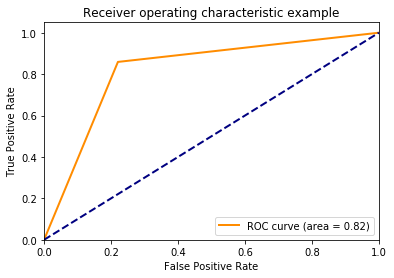

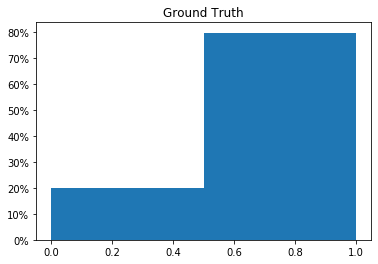

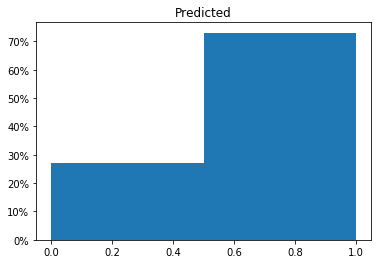

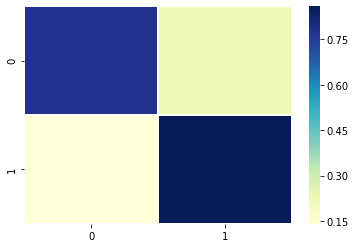

In [126]:
# test model
predY = clf.predict(testX)
print("Test Score:", clf.score(testX, testY_mod))

# get auc
auc = roc_auc_score(testY_mod, predY)
print("AUC:", auc)

# plot roc curve
fpr, tpr, _ = roc_curve(testY_mod, predY)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# class balance
plt.hist(testY_mod, bins=2, weights=np.ones(len(testY_mod)) / len(testY_mod))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Ground Truth")
plt.show()

plt.hist(predY, bins=2, weights=np.ones(len(predY)) / len(predY))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Predicted")
plt.show()

# heatmap
confusion = confusion_matrix(testY_mod, predY)
confusion = confusion / np.sum(confusion, axis=1)[:, None]
heatmap = sns.heatmap(confusion, linewidths=.5, cmap="YlGnBu")